<a href="https://colab.research.google.com/github/coderharsh2004/Deep_Learning/blob/main/PartB_Assign6_500106274_Redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np

# Parameters
latent_dim = 100  # Size of the latent vector (input to the generator)
lr = 0.0002
epochs = 50
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.84MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Load FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # Output between [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)  # Reshape to image size
        return img

generator = Generator(latent_dim).to(device)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten image to vector
        validity = self.model(img_flat)
        return validity

discriminator = Discriminator().to(device)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability
        )
 def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten image to vector
        validity = self.model(img_flat)
        return validity

discriminator = Discriminator().to(device)


In [8]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()


Epoch [10/100], d_loss: 1.2026, g_loss: 1.0820


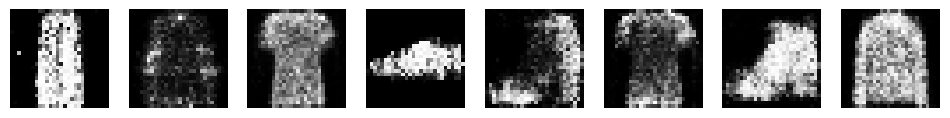

Epoch [20/100], d_loss: 1.3440, g_loss: 0.8124


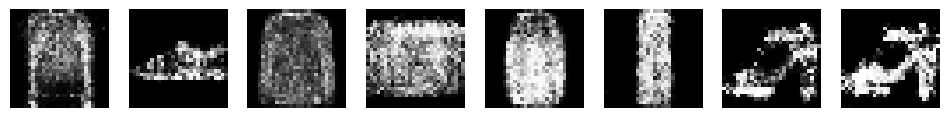

Epoch [30/100], d_loss: 1.4160, g_loss: 0.7532


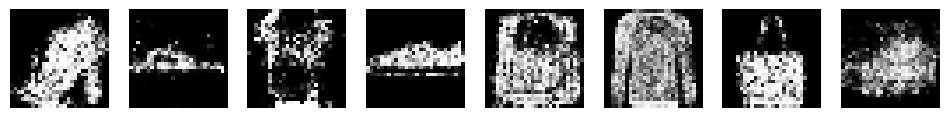

Epoch [40/100], d_loss: 1.3299, g_loss: 0.7939


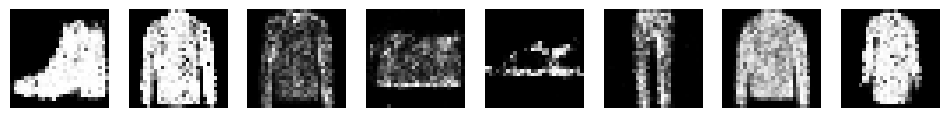

Epoch [50/100], d_loss: 1.4092, g_loss: 0.7088


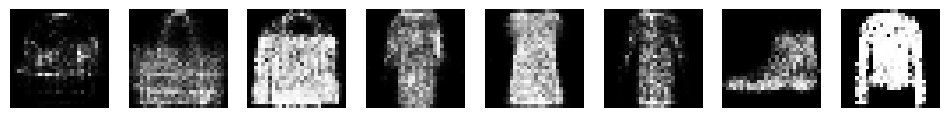

Epoch [60/100], d_loss: 1.4615, g_loss: 0.7768


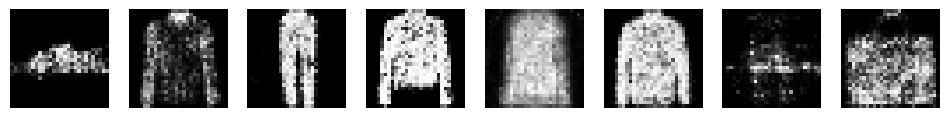

Epoch [70/100], d_loss: 1.3865, g_loss: 0.7386


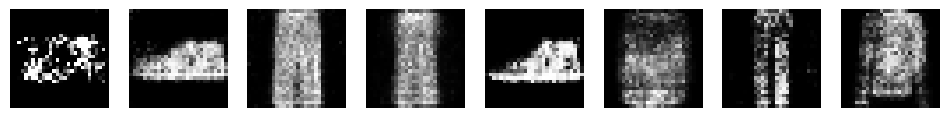

Epoch [80/100], d_loss: 1.3545, g_loss: 0.7305


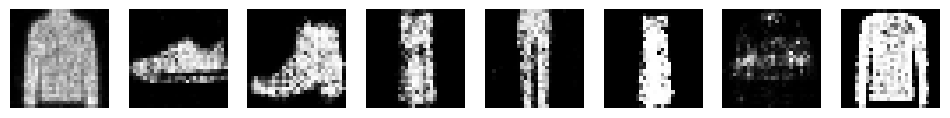

Epoch [90/100], d_loss: 1.4086, g_loss: 0.6756


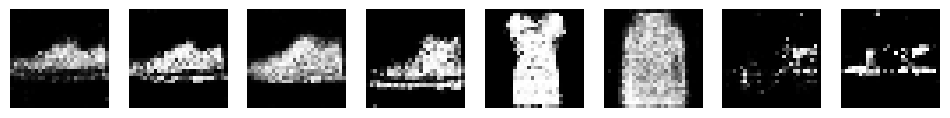

Epoch [100/100], d_loss: 1.3921, g_loss: 0.6871


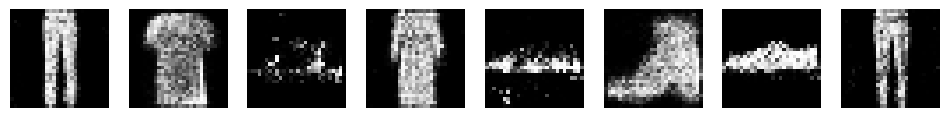

In [9]:
# Define training parameters
epochs = 100  # Increase this value for longer training
latent_dim = 100
log_interval = 10  # Print losses and generate images every `log_interval` epochs

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())  # Detach to avoid backprop to generator
        fake_loss = criterion(fake_output, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)  # We want generator to fool discriminator
        g_loss.backward()
        optimizer_g.step()

    # Print progress every `log_interval` epochs
    if (epoch + 1) % log_interval == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

        # Generate and visualize images
        with torch.no_grad():
            fake_images = generator(torch.randn(8, latent_dim).to(device))
            fake_images = fake_images.cpu().detach().numpy()
            fake_images = np.transpose(fake_images, (0, 2, 3, 1))  # Convert to shape [batch_size, H, W, C]
            fig, axes = plt.subplots(1, 8, figsize=(12, 2), dpi=100)
            for j in range(8):
                axes[j].imshow(fake_images[j, :, :, 0], cmap='gray')
                axes[j].axis('off')
            plt.show()



In [ ]:
# Save model
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [ ]:
def visualize_real_and_corresponding_generated_images(generator, dataloader, latent_dim, num_images=8):
    """
    Visualize real images and their corresponding generated images in a compact layout.

    :param generator: Trained Generator model.
    :param dataloader: DataLoader for real images.
    :param latent_dim: Latent dimension size.
    :param num_images: Number of image pairs to display (should be a multiple of 2, e.g., 8, 10).
    """
    generator.eval()  # Set generator to evaluation mode

    # Fetch real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images].to(device)

    # Generate corresponding latent vectors (one per real image)
    z = torch.randn(num_images, latent_dim).to(device)

    # Generate fake images using the latent vectors
    fake_images = generator(z)

    # Convert images to CPU and normalize for visualization
    real_images = real_images.cpu().detach().numpy()
    fake_images = fake_images.cpu().detach().numpy()

    # Normalize images to [0, 1] for better visualization
    real_images = (real_images - real_images.min()) / (real_images.max() - real_images.min())
    fake_images = (fake_images - fake_images.min()) / (fake_images.max() - fake_images.min())

    real_images = np.transpose(real_images, (0, 2, 3, 1))  # [N, H, W, C]
    fake_images = np.transpose(fake_images, (0, 2, 3, 1))

    # Create a smaller, compact figure
    fig, axes = plt.subplots(num_images, 2, figsize=(5, num_images * 1.2), dpi=100)

    for i in range(num_images):
        # Plot real image
        axes[i, 0].imshow(real_images[i, :, :, 0], cmap="gray")
        axes[i, 0].set_title("Real")
        axes[i, 0].axis("off")

        # Plot generated image
        axes[i, 1].imshow(fake_images[i, :, :, 0], cmap="gray")
        axes[i, 1].set_title("Generated")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
def enhanced_visualize_real_and_generated_images(generator, dataloader, latent_dim, num_images=16):
    """
    Enhanced visualization of real and corresponding generated images.

    :param generator: Trained Generator model.
    :param dataloader: DataLoader for real images.
    :param latent_dim: Latent dimension size.
    :param num_images: Number of image pairs to display (should be a perfect square, e.g., 16, 25).
    """
    generator.eval()  # Set generator to evaluation mode

    # Fetch real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images].to(device)

    # Generate fake images
    z = torch.randn(num_images, latent_dim).to(device)
    fake_images = generator(z)

    # Convert images to CPU and normalize for visualization
    real_images = real_images.cpu().detach().numpy()
    fake_images = fake_images.cpu().detach().numpy()

    # Normalize images to [0, 1] for better visualization
    real_images = (real_images - real_images.min()) / (real_images.max() - real_images.min())
    fake_images = (fake_images - fake_images.min()) / (fake_images.max() - fake_images.min())

    real_images = np.transpose(real_images, (0, 2, 3, 1))  # [N, H, W, C]
    fake_images = np.transpose(fake_images, (0, 2, 3, 1))

    # Create a figure with subplots
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4), dpi=150)

    for i in range(num_images):
        # Plot real image
        axes[0, i].imshow(real_images[i, :, :, 0], cmap="gray")
        axes[0, i].set_title("Real")
        axes[0, i].axis("off")

        # Plot generated image
        axes[1, i].imshow(fake_images[i, :, :, 0], cmap="gray")
        axes[1, i].set_title("Generated")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


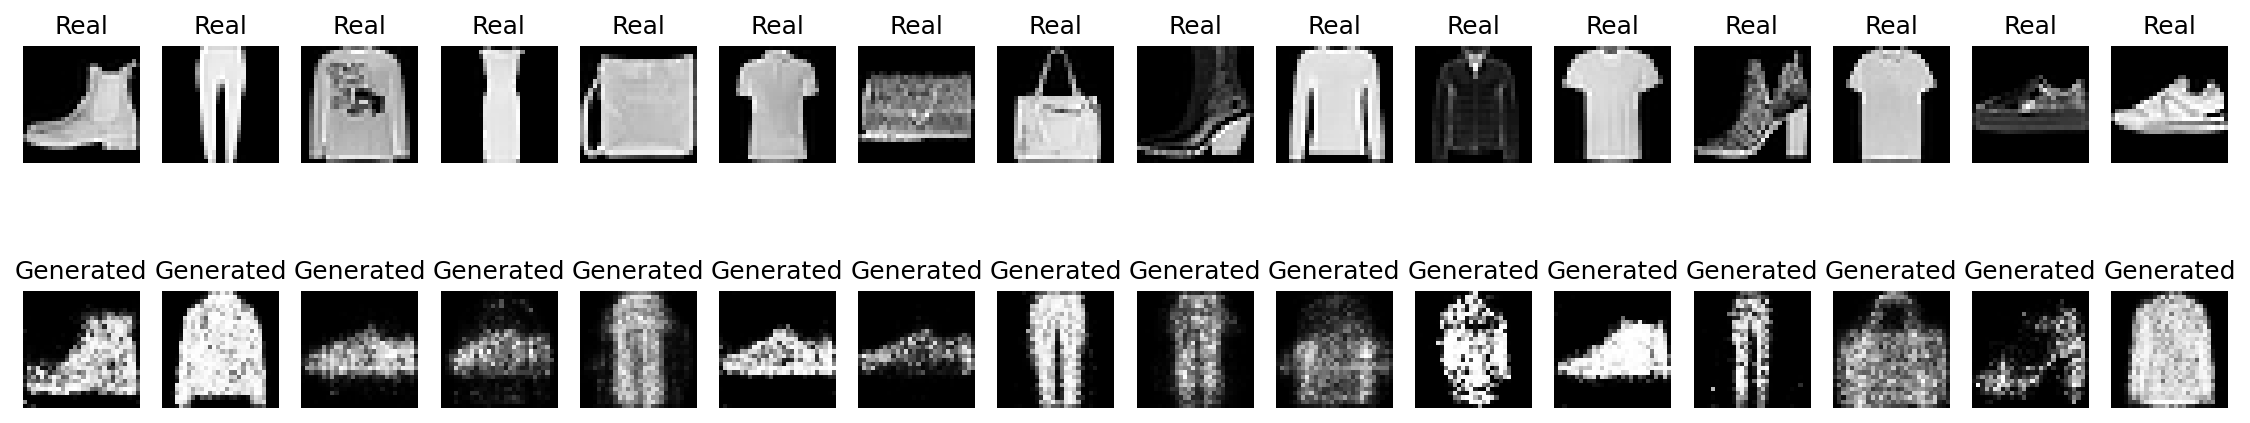

In [ ]:
enhanced_visualize_real_and_generated_images(generator, dataloader, latent_dim, num_images=16)


In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
